# **Click-Through Rate Prediction**
#### This exercise covers the steps for creating a click-through rate (CTR) prediction pipeline. 
#### ** This exercise will cover: **
+  ####*Part 1:* Parse CTR data and generate OHE features
+  ####*Part 2:* CTR prediction and logloss evaluation
 + #### *Visualization 1:* ROC curve
 
#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### **Part 1: Parse CTR data and generate OHE features**

#### **Data loading**

In [16]:
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('HandsOnML', 'dac_sample.txt')
fileName = os.path.join(baseDir, inputPath)

if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 2)
               .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
    print rawData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


#### **Splitting the data **
####  1- Splitting the data into training, validation, and test sets using the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets.
#### 2 - [Cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) each of these RDDs. 
#### 3- Compute the size of each dataset.

In [17]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest
print rawData.take(1)

79911 10075 10014 100000
[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


#### ** Creating ONE Dictionary**
#### Transforming the raw training data to an RDD containing a list of (featureID, value). We will ignore the first field (which is the 0-1 label), and parse the remaining fields (or raw features).

In [18]:
# TODO: Replace <FILL IN> with appropriate code
def parseData(data):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    
    data_chain = data.split(",")
    
    fv_tuple = list(enumerate(data_chain[1:]))
    
    return fv_tuple
    
parsedTrainFeat = rawTrainData.map(parseData)
print parsedTrainFeat.take(1)

[[(0, u'1'), (1, u'1'), (2, u'5'), (3, u'0'), (4, u'1382'), (5, u'4'), (6, u'15'), (7, u'2'), (8, u'181'), (9, u'1'), (10, u'2'), (11, u''), (12, u'2'), (13, u'68fd1e64'), (14, u'80e26c9b'), (15, u'fb936136'), (16, u'7b4723c4'), (17, u'25c83c98'), (18, u'7e0ccccf'), (19, u'de7995b8'), (20, u'1f89b562'), (21, u'a73ee510'), (22, u'a8cd5504'), (23, u'b2cb9c98'), (24, u'37c9c164'), (25, u'2824a5f6'), (26, u'1adce6ef'), (27, u'8ba8b39a'), (28, u'891b62e7'), (29, u'e5ba7672'), (30, u'f54016b9'), (31, u'21ddcdc9'), (32, u'b1252a9d'), (33, u'07b5194c'), (34, u''), (35, u'3a171ecb'), (36, u'c5c50484'), (37, u'e8b83407'), (38, u'9727dd16')]]


#### Create an OHE dictionary from the RDD with the list of (featureID, value)

In [19]:
##### OHE dictionary sample : 
#cityOHEDict[(0,'Beijing')] = 0
#cityOHEDict[(0,'Paris')] = 1
#cityOHEDict[(0,'London')] = 2
#cityOHEDict[(0,'New York')] = 3
#cityOHEDict[(1, 'Asia')] = 4
#cityOHEDict[(1, 'Europe')] = 5
#cityOHEDict[(1, 'American')] = 6
#cityOHEDict[(2, 'very much')] = 7
#cityOHEDict[(2, 'a little')] = 8

In [20]:
# TODO: Replace <FILL IN> with appropriate code
def createOneHotDictionary(inputData):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    
    DistinctFeatures = (inputData
                              .flatMap(lambda x: x).distinct())
    
    OHEDictionary = (DistinctFeatures
                            .zipWithIndex().collectAsMap())
    
    return OHEDictionary
OHEDictionary = createOneHotDictionary(parsedTrainFeat)
numCtrOHEFeats = len(OHEDictionary.keys())
print numCtrOHEFeats

233286


In [21]:
# We have 233286 features totally


#### ** Transform training data to RDD of LabeledPoint **

In [22]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector

In [23]:
# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDictionary):
    """Produce a 1-of-k encoding from a list of features and an 1-of-k dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDictionary (dict): A mapping of (featureID, value) to unique integer.

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    return SparseVector(len(OHEDictionary),sorted([(OHEDictionary[x],1.0) for x in rawFeats if x in OHEDictionary]))
def createOHELabeledPoint(data, OHEDictionary, numOHEFeats):
    """Obtain the label and feature vector for this raw observation.

    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The number of unique features in the training dataset.

    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    
    parsedFeat = parseData(data)
    
    sparseVector = oneHotEncoding(parsedFeat, OHEDictionary)
    
    return LabeledPoint(data[0],sparseVector)

OHETrainData = rawTrainData.map(lambda data: createOHELabeledPoint(data, OHEDictionary, numCtrOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

OHEValidationData = rawValidationData.map(lambda data: createOHELabeledPoint(data, OHEDictionary, numCtrOHEFeats))
OHEValidationData.cache()
print OHEValidationData.take(1)

OHETestData = rawValidationData.map(lambda data: createOHELabeledPoint(data, OHEDictionary, numCtrOHEFeats))
OHETestData.cache()
print OHETestData.take(1)

[LabeledPoint(0.0, (233286,[382,3101,6842,8311,8911,11887,12893,16211,17631,18646,23513,29366,33157,39536,55820,61797,81485,82753,93671,96986,109720,110662,112139,120263,128571,132400,132805,140595,160666,185457,190322,191105,195902,202638,204242,206037,222753,225966,229941],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
[LabeledPoint(0.0, (233286,[7623,9238,15597,21650,31238,36177,36577,39536,49203,61797,66635,67253,68245,68344,73075,76724,81421,81485,92068,96986,98511,109720,117014,121550,141683,146472,147618,171119,184096,184644,185457,185819,194734,198514,201019,210722,213593,222178,227716],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]
[LabeledPoint(0.0, (233286,[7623,9238,15597,21650,31238,36177,36577,39536,49203,61797,66635,67253,68245,68344,73075,76724,8

### ** Part 2: CTR prediction and logloss evaluation **

#### ** Log loss **
#### Throughout this exercise, we will use log loss to evaluate the quality of models.  Log loss is defined as: $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ where $ \scriptsize p$ is a probability between 0 and 1 and $ \scriptsize y$ is a label of either 0 or 1.

In [24]:
# TODO: Replace <FILL IN> with appropriate code
from math import log

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    
    if y == 1.:
        return -log(p+epsilon)
    if y == 0.:
        return -log(1-p+epsilon)
    
print computeLogLoss(.5, 1)
print computeLogLoss(.5, 0)
print computeLogLoss(.99, 1)
print computeLogLoss(.99, 0)
print computeLogLoss(.01, 1)
print computeLogLoss(.01, 0)
print computeLogLoss(0, 1)
print computeLogLoss(1, 1)
print computeLogLoss(1, 0)

0.69314718054
0.69314718054
0.0100503358434
4.60517018499
4.60517018499
0.0100503358434
25.3284360229
-1.00000008274e-11
25.3284360229


#### ** Predicted probability **
#### In order to compute the log loss for the model we train, we need to write code to generate predictions from the model. Write a function that computes the raw linear prediction from this logistic regression model and then passes it through a [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) $ \scriptsize \sigma(t) = (1+ e^{-t})^{-1} $ to return the model's probabilistic prediction. Then compute probabilistic predictions on the training data.

In [25]:
# TODO: Replace <FILL IN> with appropriate code
from math import exp #  exp(-t) = e^-t

def getProbability(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    return (1. + exp(-rawPrediction))**(-1.)

#### ** Evaluate the model **
#### To do this, write a general function that takes as input a model and data, and outputs the log loss. 

In [26]:
# TODO: Replace <FILL IN> with appropriate code
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    
    prob_lb_tup = data.map(lambda lp: (getProbability(lp.features, model.weights, model.intercept),lp.label))
    
    loss_tup = prob_lb_tup.map(lambda (x,y): computeLogLoss(x,y))
    
    return loss_tup.mean()

#### ** Traning the model with Logistic regression **
####  First use [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) to train a model using `OHETrainData` with the given hyperparameter configuration. Next, use the `LogisticRegressionModel.weights` and `LogisticRegressionModel.intercept` attributes to print out the model's parameters.

In [12]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

numIters = 80
regType = 'l2'
includeIntercept = True

# Initialize va"riables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [13]:
# TODO: Replace <FILL IN> with appropriate code
stepSizes = [1,10]
regParams = [1e-6,1e-3]
for stepSize in stepSizes:
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(OHETrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, OHEValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

	stepSize = 1.0, regParam = 1e-06: logloss = 0.483
	stepSize = 1.0, regParam = 1e-03: logloss = 0.483
	stepSize = 10.0, regParam = 1e-06: logloss = 0.454
	stepSize = 10.0, regParam = 1e-03: logloss = 0.455


#### **Visualization: ROC curve **
#### Graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied

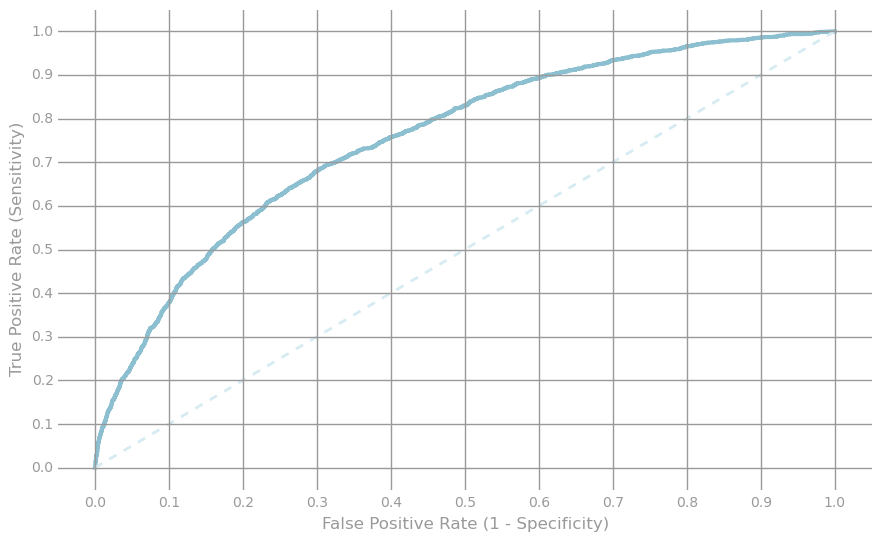

In [14]:
import matplotlib.pyplot as plt
import numpy as np
labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getProbability(lp.features, bestModel.weights, bestModel.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

#### ** (3e) Evaluate on the test set **
#### Finally, evaluate the best model on the test set.

In [15]:
# TODO: Replace <FILL IN> with appropriate code
# Log loss for the best model from (5d)
logLossTest = evaluateResults(bestModel, OHETestData)

print ('Test Dataset Log Loss:\n\tlogLossTest = {0:.3f}'
       .format(logLossTest))

Test Dataset Log Loss:
	logLossTest = 0.454
